<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/lr_and_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDive into Learning Rate and Optimizer

Mission Statement:

1. Understanding Learning Rate Finder
2. Introducing different optimization technique in PyTorch `optimizer` and its effect in learning

We will use the previous linear regression problem for simple demonstration and understanding

## Notebook Preperation

In [1]:
# Installing sstorch package
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Revisiting the linear regression problem

$y = w \times X + b + noise$



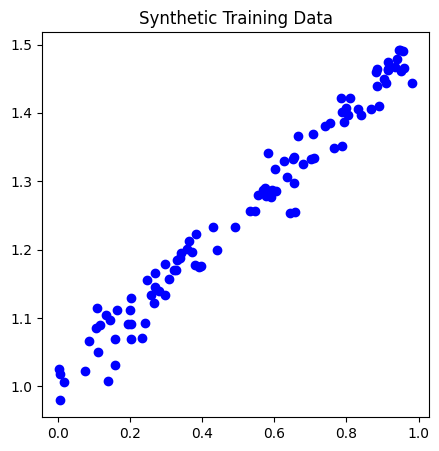

In [3]:
import torch
import matplotlib.pyplot as plt

# To ensure reproducibility
torch.manual_seed(42)

# Generating synthetic data
X = torch.rand(100, 1) # random numbers from a uniform distribution on the interval (0, 1)
w_true, b_true = 0.5, 1
noise = torch.randn(100, 1) * 0.03
y = w_true * X + b_true + noise

# Plot synthetic data
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5,5))
ax.scatter(X, y, color="b")
ax.set_title("Synthetic Training Data");

In [4]:
# Using TensorDataset to create Dataset and insert into Dataloader with batch_size of len(ds)
from torch.utils.data import TensorDataset, DataLoader

ds = TensorDataset(X, y)
dl = DataLoader(dataset=ds,
                batch_size=len(ds),
                shuffle=True)

## Setting up model, loss_fn and a basic optimizer

1. Download sstorch package for the training step using `SSTLearner` class.

2. Create our `LinearRegression` Model using `nn.Module` with simple `nn.Linear` for model setup

3. Using `nn.MSELoss` as `loss_fn`

4. using the pre-built SGD optimizer for gradient descent

In [5]:
# Setting up LinearRegression model using nn.linear
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
    def forward(self, X):
        return self.linear(X)

In [6]:
from sstorch.learner import SSTLearner

# Set manual seed
torch.manual_seed(20)

# Set model, optimizer and loss_fn
model = LinearRegression()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# Set up Learner class for training
learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     train_dataloader=dl)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.5958]])), ('linear.bias', tensor([0.9463]))])


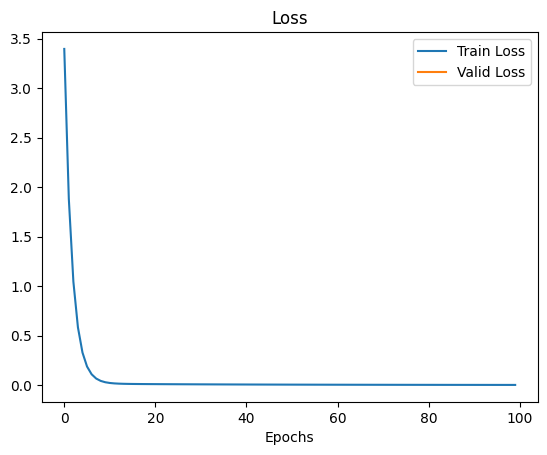

In [7]:
# Train on 100 epochs
learner.train(100, verbose=0)

# Checking the result using state_dict, we should get result of weight ~0.5, bias ~1
print(learner.model.state_dict())

# Plotting out the loss curve
learner.plot_loss_curve()

## Choosing the right initial Learning Rate

As is shown in previous notebook, choosing the learning rate is crucial in achieving optimal result.

* A learning rate that is too low, the model doesnt learn enough and loss remains high.
* A learning rate that is too high, the model doesnt converge to a solution and the loss gets higher

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/learning_rate.png?raw=true">

Choosing a learning rate that works well for a given model (and dataset) is a difficult task, one mostly done by **trial-and-error** since there is no analytical way of finding the optimal learning rate

One of the way is to perform a **grid search**, trying multiple learning rates over a few epochs each and comparing the evolution of the losses. But this process is computationally expensive since we will need to train the model multiple times

**LR Range Test**

In 2017, Leslie N.Smith published ["Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186) in which he outlines a procedure to quickly find an appropriate range for the initial learning rate - **LR Range Test**.

The idea is similer to grid search but we only run a short training session in which learning rate is increased (linearly) between two boundary values `min_lr` and `max_lr`. A thte beginning, with a small learning rate the network will start to slowly converge which results in loss values getting lower and lower. At some point, learning rate will get too large and cause network to diverge

We usually look for the best initial value of learning rate somewhere around the middle of the steepest descendingloss curve

In `SSTLearner`, we implimented a basic `lr_range_test`.

The full implimentation for LR Range Test is in https://github.com/ronald-hk-chung/sstorch/blob/main/src/sstorch/learner/lr_handler.py

For a more detail well built implimentation, we can use Python package: `torch_lr_finder`, the usage is quite similar to `SSTLearner` implimentation

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 3.42E-02 | Lowest Loss: 2.89E+00


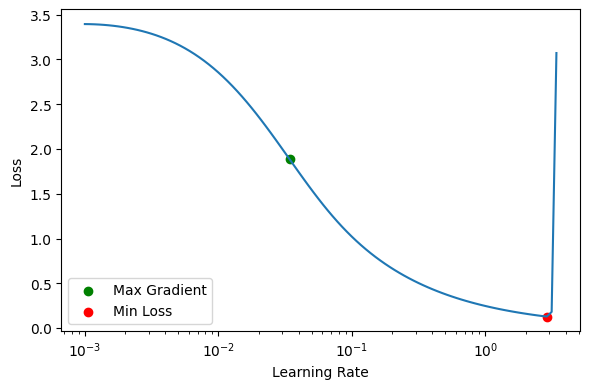

In [8]:
# Set manual seed
torch.manual_seed(20)

# Set model, optimizer and loss_fn
model = LinearRegression()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# Set up Learner class for training
learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     train_dataloader=dl)

# Run lr_range_test
learner.lr_range_test(end_lr=3.7, start_lr=1e-3, num_iter=100)

Rule of thumb for choosing the initial LR is to pick a spot that is an order of mangitude less than minimum. In our case, in between Max Gradient and Min Loss ~0.1 would be fine

## Setting up Learner class for recording intermediate results for visualizing the path of gradient desccent

We will try to walk through some gradient descent optimization algorithms and have some intuition on how they work with their implimentation.

But before we start, we would like to impliment a `Learner` class that subclass `SSTLearner` and capsulate a `plot_path()` - a function to plot out the path of descent the loss surface for our linear regression problem.

We add `capture_parameters()` to add a forward hook to record the parameters that are used in each step in our optimization.



In [9]:
import numpy as np

class Learner(SSTLearner):
    def __init__(self, model, loss_fn, optimizer, train_dataloader, valid_dataloader=None):
        super().__init__(model=model,
                         loss_fn=loss_fn,
                         optimizer=optimizer,
                         train_dataloader=train_dataloader,
                         valid_dataloader=valid_dataloader)

        # Initialise results list for w and b
        self.results['w']=[]
        self.results['b']=[]

        # Grid Search operation for all losses for loss_surface plot
        # Split the ranges in 100 evenly space intervlas each
        w_range = np.linspace(w_true - 2, w_true + 2, 101)
        b_range = np.linspace(b_true - 2, b_true + 2, 101)

        # Use mesgrid to generates a grid of w and b for all combination
        self.bs, self.ws = np.meshgrid(b_range, w_range)

        # Make all predictions according to the generated grid of w and b
        all_predictions = np.apply_along_axis(func1d=lambda x: self.ws * x + self.bs,
                                              axis=1,
                                              arr=X.numpy().reshape(-1, 1))

        # Calculate all errors (errors per data point) per points in grid
        all_labels = y.numpy().reshape(-1, 1, 1)
        all_errors = (all_predictions - all_labels)

        # Calculate losses (MSE) per points in grid
        self.all_losses = (all_errors ** 2).mean(axis=0)


    def capture_parameters(self, layer_to_hook):
        '''Adding a forward hook function to record parameters w and b in results dictionary

        Args:
            layer_to_hook (list): list of named layer to add hook function
        '''
        def fw_hook_fn(layer, inputs, outputs):
            """hook function to record reuslts of weight and bias"""
            if self.model.training:
                self.results['w'].append(layer.weight.item())
                self.results['b'].append(layer.bias.item())

        self.attach_forward_hooks(layer_to_hook, fw_hook_fn)

    def plot_path(self):
        """Plotting out a 3d loss surface and a contour with its path of gradient descent"""
        figure = plt.figure(figsize=(12, 6))

        # 1st plot - 3d surface plot with minimum point and starting point
        ax1 = figure.add_subplot(1, 2, 1, projection='3d')
        ax1.set_xlabel('b')
        ax1.set_ylabel('w')
        ax1.set_title('Loss Surface')
        ax1.plot_surface(self.bs, self.ws, self.all_losses, rstride=1, cstride=1, alpha=.5, cmap=plt.cm.jet, linewidth=0, antialiased=True)
        ax1.scatter(b_true, w_true, torch.nn.functional.mse_loss(model(X), y).item(), c="k", label='Minimum')
        ax1.plot(self.results['b'], self.results['w'], self.results['train_loss'], c='r', marker='o', ms=3)
        ax1.legend()

        # 2nd plot - contour
        ax2 = figure.add_subplot(1, 2, 2)
        ax2.set_xlabel('b')
        ax2.set_ylabel('w')
        ax2.set_title('Loss Contour')
        ax2.contour(self.bs[0, :], self.ws[:, 0], self.all_losses, cmap=plt.cm.jet)
        ax2.scatter(b_true, w_true, c='k', label='Minimum')
        ax2.plot(self.results['b'], self.results['w'], c='r', marker='o', ms=3)
        ax2.legend();

    def plot_lr(self):
        """Plot out learning rate"""
        plt.plot(self.results['lr'])
        plt.xlabel('Epoch')
        plt.ylabel('Learning rate')
        plt.title('Average Learning Rate');

## Stochastic Gradient Descent (SGD Optimizer)

Stochastic Gradient Descent (SGD) is the simplest optimization algorithm - taking current model parameter $\theta_t$ and subtract the gradient of those parameters, $\nabla_\theta f(\theta_t)$, multiplied by the "learning rate", $\gamma$.

The SGD algorithm is:

<br/>

$$
\theta_{t+1} = \theta_t - \gamma \cdot \nabla_\theta f(\theta_t)
$$

where

* $\gamma$ is the learning rate
* $\theta$ is the parameters
* $f(\theta_t)$ is the objective function of parameters
* $\nabla_\theta f(\theta_t)$ denotes the gradient of objective function

<br/>

**Gradient Descent vs. Stochastic Gradient Descent**

*  **Gradient descent** means we calculate the gradient using every single example in our training set and then do a single parameter update. This is relatively slow as in our experiments it means only updating the parameters after seeing all 100 examples.

*  **Stochastic gradient descent** which means we update our parameters after every single example. This is usually very noisy, so a happy medium is updating the parameters after we have seen a *batch* of examples,  **Mini-batch gradient descent**.

*  **On-line gradient descent** which usually implies our model is in production and is being constantly fed new examples on which it is using to update its parameters.

Note that in this exercise because of small dataset, we are employing **Gradient Descent**


## Define custom SimpleSGD optimizer

In [10]:
from torch.optim import Optimizer

class SimpleSGD(Optimizer):
    def __init__(self, params, lr):
        super().__init__(params, defaults={'lr': lr})

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                p.grad = None

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                p.data -= group['lr'] * p.grad.data


## Train our model with SimpleSGD

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.5958]])), ('linear.bias', tensor([0.9463]))])


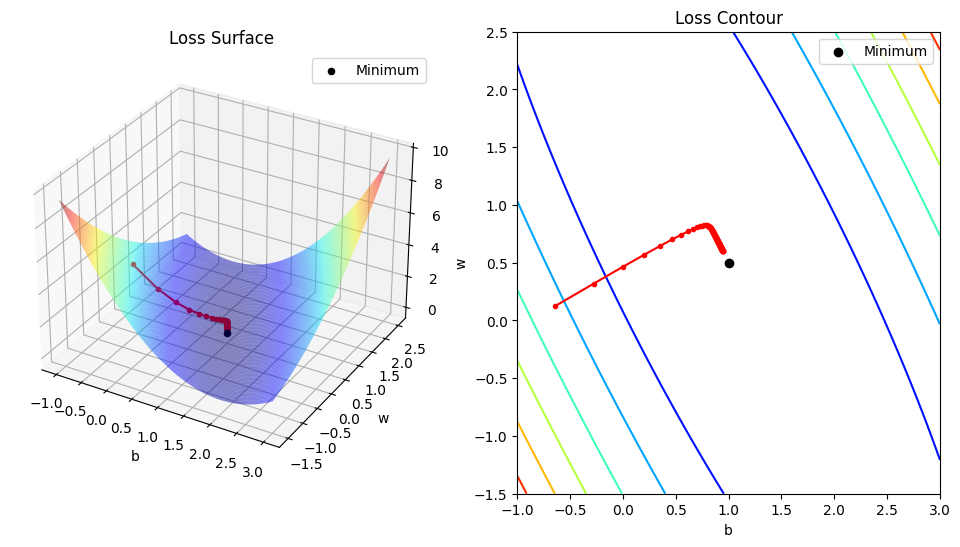

In [11]:
# Set manual seed
torch.manual_seed(20)

# Set model and loss_fn
model = LinearRegression()
loss_fn = nn.MSELoss()

# Define optimizer, choose between default torch.optim.SGD or SimpleSGD
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
optimizer = SimpleSGD(params=model.parameters(), lr=0.1)

learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl)

# Adding forward hook to linear to record parameters
learner.capture_parameters(['linear'])

# Train for 100 epochs
learner.train(100, verbose=0)

# Remove all hooks for further calculation
learner.remove_hooks()

# Print out state dict to show results
print(learner.model.state_dict())

# Plot out path taken
learner.plot_path()

## SGD with Momentum

One of the problem of a basic SGD is that the global minima will have very low gradients where SGD only give small update steps and make learning slow.

SGD with momentum adds "momentum" tried to resolve this problem with optimizer keeping the "momentum" gained rolling down the steep gradient while its going across the flat areas

Below shows the PyTorch implimentation on adding momentum to SGD:

<br/>

$$
\theta_{t+1,i} = \theta_{t,i} - \eta \cdot v_{t,i}
$$

$$
v_{t,i} = \gamma \cdot v_{t-1,i} + (1-\tau)\nabla_\theta J(\theta_{t,i})
$$


where

* $\eta$ is the learning rate
* $\gamma$ is the momentum factor
* $v$ is the velocity that is used to update paremeter $\theta$
* $\nabla_\theta J(\theta_{t,i})$ is the gradient of the loss function for $\theta_i$ time $t$
* $\tau$ is the dampening factor

<br/>

If the momentum is zero, the model will not care about the previous velocity at all and alogirthm becomes a basic SGD.


<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/sgd_implimentation.png?raw=true">

In [12]:
from torch.optim import Optimizer

class SGDMomentum(Optimizer):
    def __init__(self, params, lr, momentum, dampening):
        super().__init__(params, defaults={'lr': lr, 'momentum': momentum, 'dampening': dampening})
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {'velocity': torch.zeros_like(p.data)}

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                p.grad = None

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['velocity'] = group['momentum'] * self.state[p]['velocity'] + (1- group['dampening']) *p.grad.data
                p.data -= group['lr'] * self.state[p]['velocity']

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.4870]])), ('linear.bias', tensor([1.0064]))])


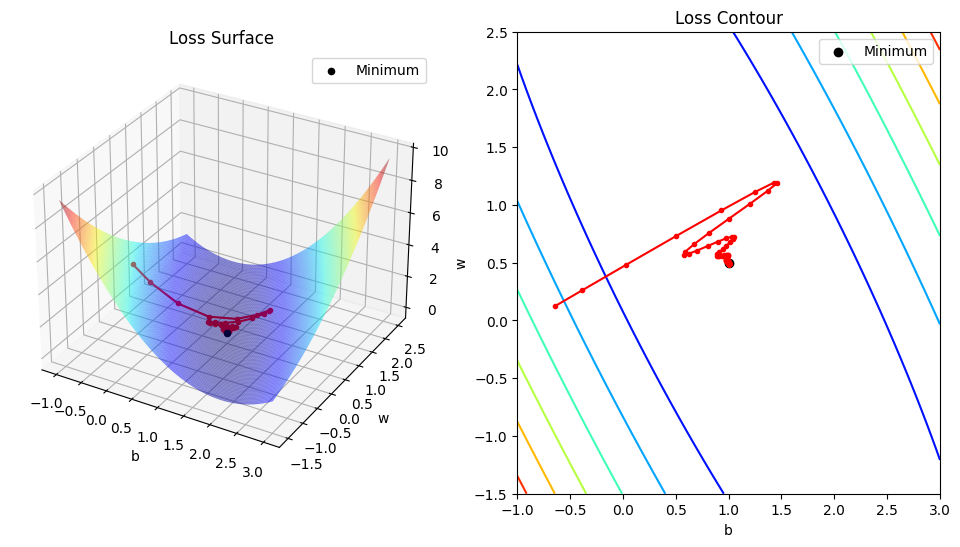

In [13]:
# Set manual seed
torch.manual_seed(20)

# Set model, loss_fn and optimizer
model = LinearRegression()
loss_fn = nn.MSELoss()

# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, momentum=0.8, dampening=0.3)
optimizer = SGDMomentum(params=model.parameters(), lr=0.1, momentum=0.8, dampening=0.3)

learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl)

# Adding forward hook to linear to record parameters
learner.capture_parameters(['linear'])

# Train for 100 epochs
learner.train(100, verbose=0)

# Remove all hooks for further calculation
learner.remove_hooks()

# Print out state dict to show results
print(learner.model.state_dict())

# Plot out path taken
learner.plot_path()

Note that the velocity `v` is a list of tensors corresponding to the model parameters. In teh case of `torch.optim.SGD`, the momentum values are stored in a dictionary under the `momentum_buffer` keys

In [14]:
optimizer.state_dict()

{'state': {0: {'velocity': tensor([[0.0006]])},
  1: {'velocity': tensor([-0.0003])}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0.8,
   'dampening': 0.3,
   'params': [0, 1]}]}

As shown from above, SGD with momentum is faster than stochastic graident descent. With momentum, the trajectory is faster when the slope is steep. Note that the trajectory of gradient descent initially overshoot as it runs into the flatter surface but manage to change its course and return to the global minima. This characteristic is sometimes beneficials in escaping local minima to reach global minima.

## Adagrad optimizer

Major downside with SGD is that we use a single learning rate across all of our parameters, and that this learning rate is fixed through the entirety of training.

Ideally, parameters that are updated more frequently have a lower learning rate and parameters that are updated infrequently have a larger learning rate. **AdaGrad** deals with the aforementioned problem by independently adapting the learning rate for each weight component. If gradients corresponding to a certain weight vector component are large, then the respective learning rate will be small. Inversely, for smaller gradients, the learning rate will be bigger. This way, Adagrad deals with vanishing and exploding gradient problems.

<br/>

$$
\theta_{t+1,i} = \theta_{t,i} - \frac{\gamma}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i})
$$

$$
G_{t,i} = G_{t-1,i} + \Big(\nabla_\theta J(\theta_{t,i})\Big)^2
$$

where

* $G_{t,i}$ which is the sum of the squared gradients for parameter $i$ up to, and including, time-step $t$.

<br/>

$G_{t,i}$ is initialized to some value, usually zero by default. As the square of the gradients of a parameter are accumulated, $G_{t,i}$ increases, and thus reduces the learning rate for parameter $i$.

The greatest advantage of AdaGrad is that there is no longer a need to manually adjust the learning rate as it adapts itself during training. But with the learning rate constantly decays with the increase of iterations (the learning rate is always divided by a positive cumulative number). Therefore, the algorithm tends to converge slowly during the last iterations where it becomes very low.


<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/adagrad_implimentation.png?raw=true">

In [15]:
from torch.optim import Optimizer

class CustomAdagrad(Optimizer):
    def __init__(self, params, lr, initial_accumulator_value=0, eps=1e-10):
        defaults = {'lr': lr,
                    'initial_accumulator_value': initial_accumulator_value,
                    'eps': eps}
        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {'sum': torch.full_like(p.data, initial_accumulator_value)}

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                p.grad = None

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['sum'] = self.state[p]['sum'] + p.grad.data ** 2
                p.data -= group['lr'] * p.grad.data/(self.state[p]['sum'].sqrt() + group['eps'])

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[1.1567]])), ('linear.bias', tensor([0.5024]))])


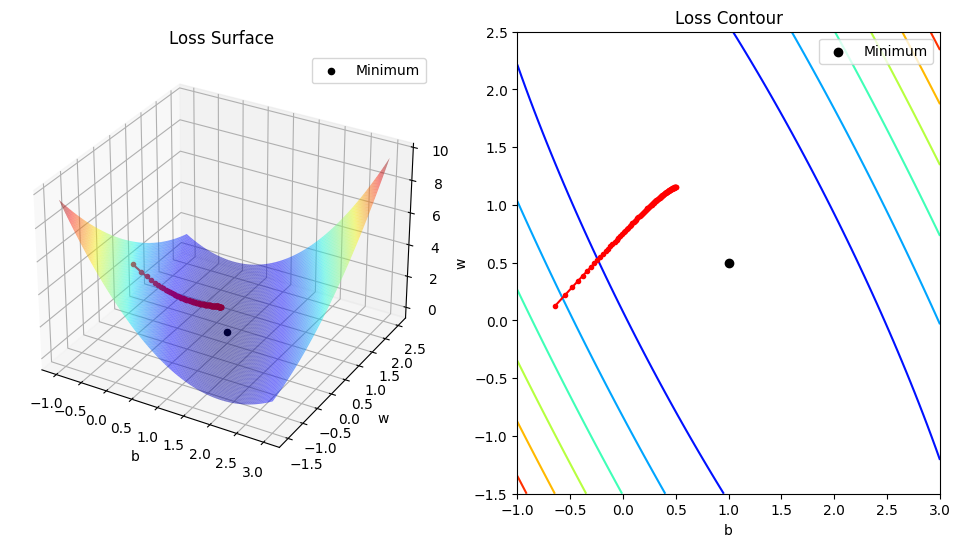

In [16]:
# Set manual seed
torch.manual_seed(20)

model = LinearRegression()
loss_fn = nn.MSELoss()

# optimizer = torch.optim.Adagrad(params=model.parameters(), lr=0.1)
optimizer = CustomAdagrad(params=model.parameters(), lr=0.1)



learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl)

# Adding forward hook to linear to record parameters
learner.capture_parameters(['linear'])

# Train for 100 epochs
learner.train(100, verbose=0)

# Remove all hooks for further calculation
learner.remove_hooks()

# Print out state dict to show results
print(learner.model.state_dict())

# Plot out path taken
learner.plot_path()

Note that in our case, the learning rate decays too fast and will need higher initial lr to get reasonable results for Adagrad optimizer

In [17]:
optimizer.state_dict()

{'state': {0: {'sum': tensor([[45.2511]])}, 1: {'sum': tensor([188.2682])}},
 'param_groups': [{'lr': 0.1,
   'initial_accumulator_value': 0,
   'eps': 1e-10,
   'params': [0, 1]}]}

## RMSProp Optimizer

RMSProp was elaborated as an improvement over AdaGrad which tackles the issue of learning rate decay.

Adagrad attempts to adjust parameter with below steps:

<br/>

$$
\Delta \theta_{t,i} = - \frac{\gamma}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i}))
$$

<br/>

The problem of the Adagrad algorithm was that $G$ was monotonically increasing which means learning is decreasing and may grind to zero as iterations increases. RMSProp solves this problem by taking the Adagrad algorithm and replacing $G_{t, i}$ with $E[g^2]_{t, i}$, an exponential moving average of the square of the gradients

<br/>

$$
E[g^2]_{t,i} = \alpha E[g^2]_{t-1,i} + (1-\alpha)g^2_{t,i}
$$

where

* $g_{t,i} = \nabla_\theta J(\theta_{t,i})$, is the gradient of the loss function wiht respect to the parameters $i$ at time $t$

* $\alpha$ is a decay factor that controls how much we care about the previous gradients in the exponential moving average, $\alpha=0$ means we don't care about previous exponential moving average at all. Default $\alpha$ is set to around 0.99

* $E[g^2]$ is the expoentially weighted average of the squared gradients

* $\epsilon$ is a small constant to prevent division by zero

<br/>

We can rewrite the update steps in terms of the parameter for RMSProp as below:

<br/>

$$\theta_{t+1,i} = \theta_{t,i} + \Delta \theta_{t,i}$$

$$\Delta \theta_t = - \frac{\gamma}{\sqrt{E[g^2]_{t,i}} + \epsilon} \cdot g_{t,i}$$

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/rmsprop_implimentation.png?raw=true">



In [18]:
from torch.optim import Optimizer

class CustomRMSprop(Optimizer):
    def __init__(self, params, lr, alpha=0.99, eps=1e-8):
        defaults = {'lr': lr,
                    'alpha': alpha,
                    'eps': eps}
        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {'square_avg': torch.zeros_like(p.data)}

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                p.grad = None

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['square_avg'] = self.state[p]['square_avg'] * group['alpha'] + (1 - group['alpha']) * p.grad.data ** 2
                p.data -= group['lr'] * p.grad.data/(self.state[p]['square_avg'].sqrt() + group['eps'])

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.4867]])), ('linear.bias', tensor([1.0066]))])


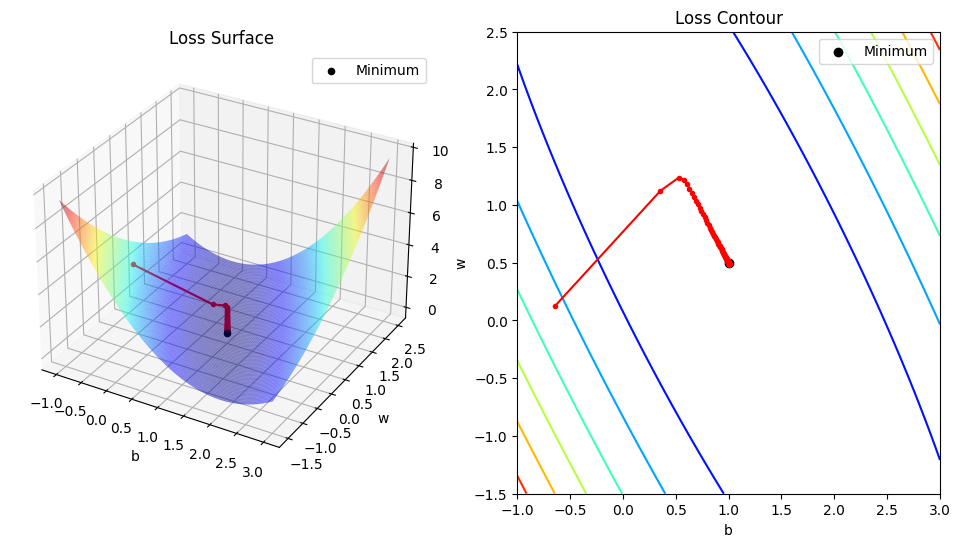

In [19]:
# Set manual seed
torch.manual_seed(20)

model = LinearRegression()
# optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.1)
optimizer = CustomRMSprop(params=model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl)

# Adding forward hook to linear to record parameters
learner.capture_parameters(['linear'])

# Train for 100 epochs
learner.train(100, verbose=0)

# Remove all hooks for further calculation
learner.remove_hooks()

# Print out state dict to show results
print(learner.model.state_dict())

# Plot out path taken
learner.plot_path()

In [20]:
optimizer.state_dict()

{'state': {0: {'square_avg': tensor([[0.0146]])},
  1: {'square_avg': tensor([0.0520])}},
 'param_groups': [{'lr': 0.1, 'alpha': 0.99, 'eps': 1e-08, 'params': [0, 1]}]}

## Adam (Adaptive Moment Estimator) Optimizer

At a high level, Adam combines Momentum and RMSProp algorithms.

Adam has an expoential moving average of the gradients, like the momentum term that can be added to SGD, and an expoential moving average of the sqaured gradients, like RMSProp and Adadelta

<br/>

$$
\theta_{t+1} = \theta_t - \gamma \cdot \frac{m_{t,i}}{\sqrt{v_{t,i}}+\epsilon}
$$

where:

$$
m_{t,i} = \beta_1 m_{t-1,i} + (1-\beta_1)g_{t,i}
$$

$$
v_{t,i} = \beta_2 v_{t-1,i} + (1-\beta_2)g_{t,i}^2
$$

<br/>

* $m_{t_i}$ is equal to $v_{t_i}$ from SGD with momentum if it had a $(1-\beta_1)$ term

* $v_{t, i}$ is equal to  $E[g^2]_{t, i}$ from RMSProp and Adadelta with $\beta_2$ replaced $\rho$ as a decay factor

<br/>

Since $m$ and $v$ are initialized to zero and $\beta_1$ and $\beta_2$ are initialised close to one. The first few update steps are *biased* towards very small values. To mitigate the problem, Adam uses *bias corrected* values of $m$ and $v$ as below:

$$
\hat{m_{t, i}} = \frac{m_{t, i}}{1-\beta_1^t}
$$

$$
\hat{v_{t, i}} = \frac{v_{t, i}}{1-\beta_2^t}
$$

<br/>

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/adam_implimentation.png?raw=true">

In [21]:
from torch.optim import Optimizer

class CustomAdam(Optimizer):
    def __init__(self, params, lr, betas=(0.9, 0.99), eps=1e-8):
        defaults = {'lr': lr,
                    'betas': betas,
                    'eps': eps}
        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = {'exp_avg': torch.zeros_like(p.data),
                                 'exp_avg_sq': torch.zeros_like(p.data),
                                 'step': 0}

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                p.grad = None

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['step'] += 1
                self.state[p]['exp_avg'] = group['betas'][0] * self.state[p]['exp_avg'] + (1 - group['betas'][0]) * p.grad.data
                self.state[p]['exp_avg_sq'] = group['betas'][1] * self.state[p]['exp_avg_sq'] + (1 - group['betas'][1]) * p.grad.data ** 2
                exp_avg_corrected = self.state[p]['exp_avg'] / (1 - group['betas'][0] ** self.state[p]['step'])
                exp_avg_sq_corrected = self.state[p]['exp_avg_sq'] / (1 - group['betas'][1] ** self.state[p]['step'])
                p.data -= group['lr'] * exp_avg_corrected / (exp_avg_sq_corrected.sqrt() + group['eps'])

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.5656]])), ('linear.bias', tensor([0.9660]))])


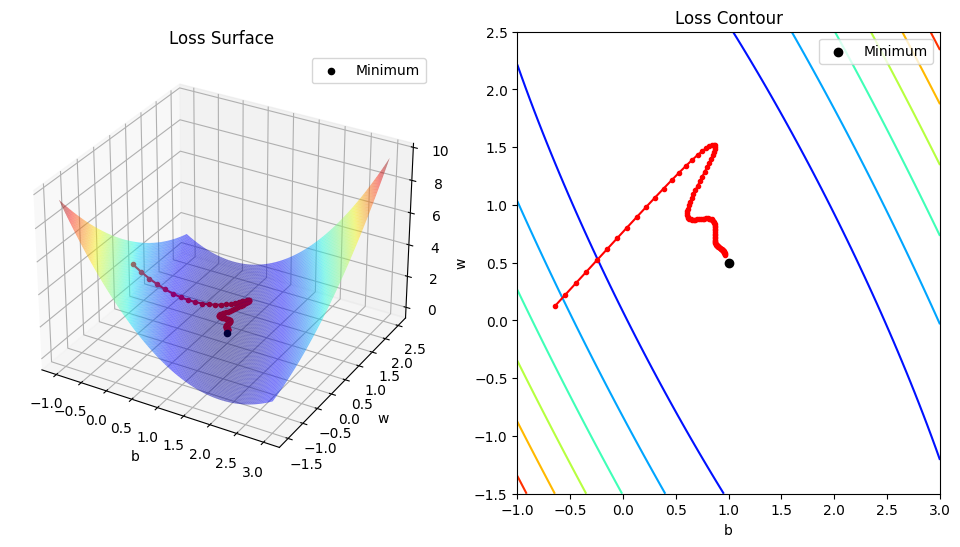

In [22]:
# Set manual seed
torch.manual_seed(20)

model = LinearRegression()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
optimizer = CustomAdam(params=model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl)

# Adding forward hook to linear to record parameters
learner.capture_parameters(['linear'])

# Train for 100 epochs
learner.train(100, verbose=0)

# Remove all hooks for further calculation
learner.remove_hooks()

# Print out state dict to show results
print(learner.model.state_dict())

# Plot out path taken
learner.plot_path()

In [23]:
optimizer.state_dict()

{'state': {0: {'exp_avg': tensor([[0.0191]]),
   'exp_avg_sq': tensor([[0.0832]]),
   'step': 100},
  1: {'exp_avg': tensor([-0.0067]),
   'exp_avg_sq': tensor([0.2777]),
   'step': 100}},
 'param_groups': [{'lr': 0.1,
   'betas': (0.9, 0.99),
   'eps': 1e-08,
   'params': [0, 1]}]}

With Adam optimizer, we can see that it has both the effect on
* momentum with faster trajectory when slope is steep
* second order adjustment per each gradients that produces a smooth curve to the minima

## Learning Rate Schedulers

Learning Rate Scheduler allow us to schedule the changes in learning rate as training goes, instead of adapting the gradients. It updates the leraning rate of the optimizer

The **scheduler** has a `step()` method whcih is called after **optimizer's** `step()`

We need to devide scheudlers into 3 groups:
1. **Epoch Schedulers** - scheulders that update the leraning rate at every epochs
2. **Validation Loss Schedulers** - scheudlers that only updates the leraning rate when the validation loss seems to be stuck
3. **Batch Schedulers** - schedulers that update hte leraning rate after every mini-batch


## Epoch Schedulers

These schedulers have their `step()` method called at the end of every epoch.

To incorporate inside our training loop:
```python
for epoch in epochs:
    for X, y in dataloader:
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # on epoch end
    scheduler.step()
```

Below are the typical **Epoch Scheduler**

* **StepLR** - it multiples the learning rate by a factor of *gamma* every step_size epochs

* **MultiStepLR** - it multiplies the learning rate by a factor *gamma* at the epochs indicated int eh list of milestones

* **ExponentialLR** - it multiples the learning rate by a factor *gamma* every epoch, no exceptions

* **LambdaLR** - it takes your own customized function that shoul take the epoch as an argument and retusn the corresponding multiplicative factor with respoect to the initial learning rate

* **CosineAnnealingLR** - it uses a technique called cosine annealing to update the learning rate

Below shows an example usage of Epoch Scheduler with SSTlearner

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.5498]])), ('linear.bias', tensor([0.9655]))])


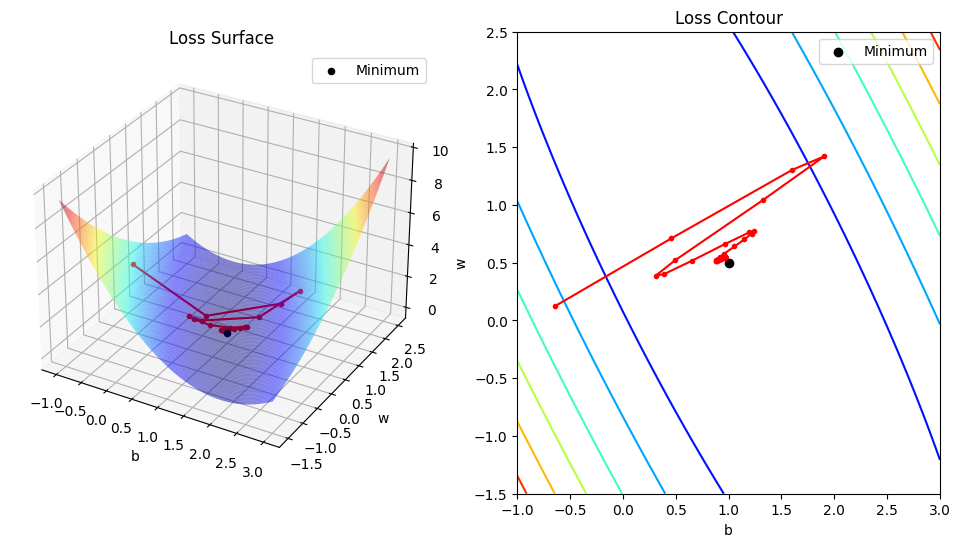

In [24]:
# Set manual seed
torch.manual_seed(20)

model = LinearRegression()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.3,
                            momentum=0.8)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                            step_size=5,
                                            gamma=0.5)

learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl)

# Set learning rate scheduler
learner.set_lr_scheduler(scheduler=scheduler,
                         is_batch_lr_scheduler=False)

# Adding forward hook to linear to record parameters
learner.capture_parameters(['linear'])

# Train for 50 epochs
learner.train(50, verbose=0)

# Remove all hooks for further calculation
learner.remove_hooks()

# Print out state dict to show results
print(learner.model.state_dict())

# Plot out path taken
learner.plot_path()

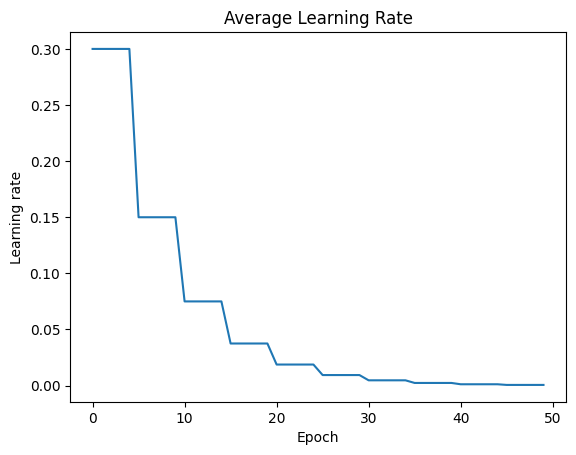

In [25]:
learner.plot_lr()

## Validation Loss Scheduler

The **ReduceLROnPlateau** scheduler also runs its `step()` function on epoch end, but it does not follow a predefined sheulde while calling its `step()` function

The `step()` function takes a validation loss as an argument and the scheduler can be configured to tolerate a lack of improvement in the loss to a thresold up to a given number of epochs named *patience* arguemnt. After the scheduler run out of patience, it update the learning rate, multiplying it by the factor.

Below shows the sample usage on **ReduceLROnPlateau** scheduler

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.4823]])), ('linear.bias', tensor([1.0127]))])


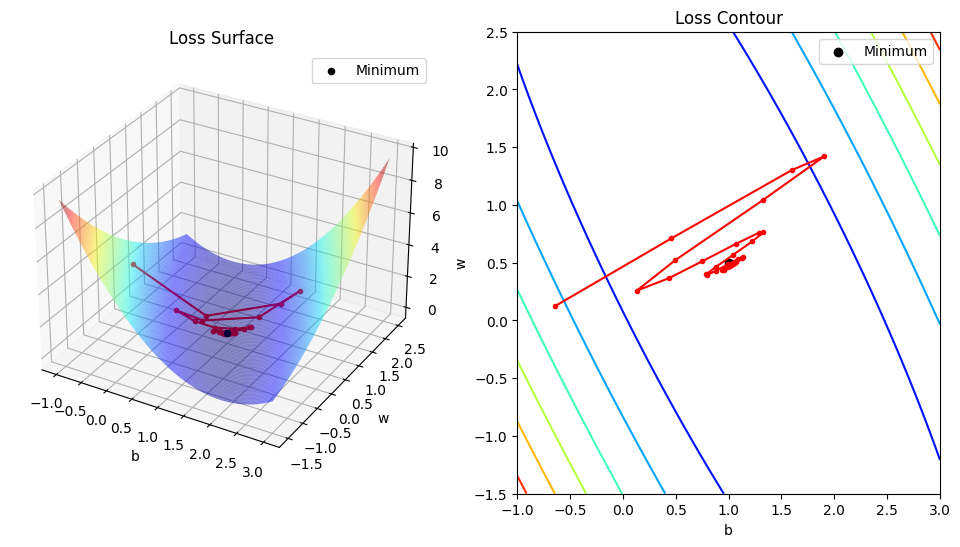

In [26]:
# Set manual seed
torch.manual_seed(20)

model = LinearRegression()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.3,
                            momentum=0.8)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.5,
                                                       patience=5,
                                                       threshold=1e-2)

learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl,
                  valid_dataloader=dl)

# Set learning rate scheduler
learner.set_lr_scheduler(scheduler=scheduler,
                         is_batch_lr_scheduler=False)

# Adding forward hook to linear to record parameters
learner.capture_parameters(['linear'])

# Train for 50 epochs
learner.train(50, verbose=0)

# Remove all hooks for further calculation
learner.remove_hooks()

# Print out state dict to show results
print(learner.model.state_dict())

# Plot out path taken
learner.plot_path()

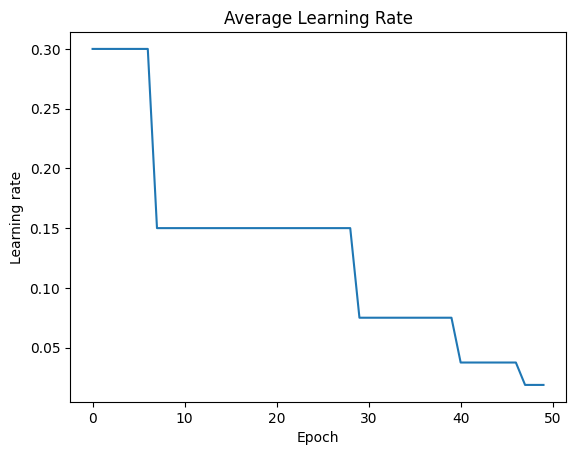

In [27]:
learner.plot_lr()

## Batch Scheduler

Batch Scheduler have their `step()` called at the end of every batch. They are all **cyclical** scheduler

* **CyclicLR** - This cycles between *base_lr* and *max_lr* and disregards the initial learning rate set in the optimizer, using *step_size_up* updates to go from base to the max learning rate, and *step_size_down* updates ot go back. This behaviour corresponds to `mode=triangular`. Additionally, it is possible to shrink the amplitude using different modes: `triangular2` will halve the amplitude after each cycle, while`exp_range` will exponentially shrink the amplitude using *gamma* as base and the number of the cycle as the exponent. The typical choice of value for *max_lr* is the learning rate found using the LR Range Test

* **OneCycleLR** - This uses a method called annealing to update the learning rate from its initial value up to a defined maximum learning rate *max_lr* and then down to a much lower learning rate over a *total_step* number of updates thus performing a single cycle.

* **CosineAnnealingWarmRestarts** - This uses cosine annealing to update the learning rate

Under SSTLearner, we have implimented `fit_one_cycle` as below:

```python
def fit_one_cycle(self, epochs, max_lr=None, min_lr=None):
    """Method to perform fit one cycle polcy

    Sets the learning rate of each parameter group according to the 1cycle learning rate policy.
    The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate
    and then from that maximum learning rate to some minimum learning rate

    Args:
        epochs (int): The number of epochs to train for
        max_lr (float):   Upper learning rate boundaries in the cycle for each parameter group, Default: None
        min_lr (float):   Lower learning rate boundaries in the cycle for each parameter group, Default: None

        If max_lr and min_lr is not specified,
        lr_range_test will be performed
        with max_lr set to min_loss_lr and min_lr set to max_grad_lr

    Reference: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
    Reference: https://arxiv.org/abs/1708.07120
    """
    if max_lr is None or min_lr is None:
        max_grad_lr, min_loss_lr = self.lr_range_test(
            end_lr=1, num_iter=100, step_mode="exp", show_graph=False
        )
        max_lr = max_lr if max_lr else min_loss_lr
        min_lr = min_lr if min_lr else max_grad_lr

    print(f"Max LR: {max_lr:.1E} | Min LR: {min_lr:.1E}")
    pervious_optimizer = deepcopy(self.optimizer)
    self.set_lr(min_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        self.optimizer,
        max_lr=max_lr,
        total_steps=int(len(self.train_dataloader) * epochs * 1.05),
    )
    self.set_lr_scheduler(scheduler=scheduler, is_batch_lr_scheduler=True)
    self.train(epochs=epochs)
    self.set_lr_scheduler(scheduler=None)
    self.optimizer = pervious_optimizer


```

  0%|          | 0/100 [00:00<?, ?it/s]

Max LR: 9.9E-01 | Min LR: 3.0E-01


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

OrderedDict([('linear.weight', tensor([[0.5747]])), ('linear.bias', tensor([1.0955]))])


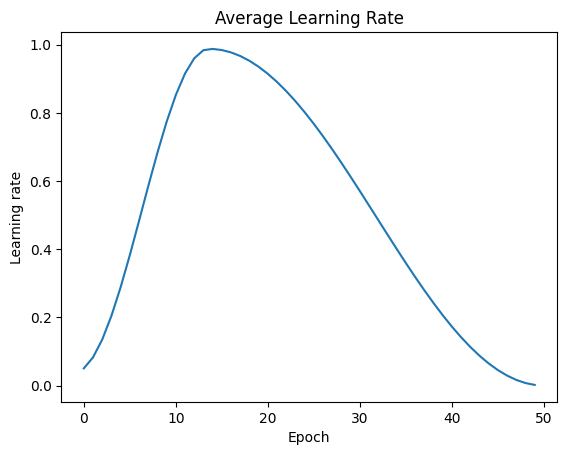

In [30]:
# Set manual seed
torch.manual_seed(20)

model = LinearRegression()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.3,
                            momentum=0.8)
loss_fn = nn.MSELoss()

learner = Learner(model=model,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  train_dataloader=dl)

# Train for 50 epochs
learner.fit_one_cycle(50, verbose=0)

# Print out state dict to show results
print(learner.model.state_dict())

learner.plot_lr()

## Adaptive vs Cycling

Although adaptive learning rates are considered competitors of cyclical learning rates, this does not prevent you from combining them and cycling learning rates while using Adam. While Adam adapts the gradients using its Exponential Weighted Moving Average, the cycling policy modifies the leraning rate itself, so they can work together indeed.